In [1]:
from glob import glob
from astropy.coordinates import SkyCoord

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import numpy as np
import pandas as pd

from piaa import utils

### Get Files

For these utilities we plate-solve each CR2 file because we need to use the WSC from each individual image. Once the tracking model is improved we will use just the WSC from the first image in the sequence.

In [2]:
field_dir = '/var/panoptes/images/fields/Kic8462852/20160811T061415/'

In [3]:
seq_files = glob("{}/ee*.cr2".format(field_dir))
seq_files.sort()
seq_files[0:5]

['/var/panoptes/images/fields/Kic8462852/20160811T061415/ee04d1_000_000.cr2',
 '/var/panoptes/images/fields/Kic8462852/20160811T061415/ee04d1_000_002.cr2',
 '/var/panoptes/images/fields/Kic8462852/20160811T061415/ee04d1_000_003.cr2',
 '/var/panoptes/images/fields/Kic8462852/20160811T061415/ee04d1_000_004.cr2',
 '/var/panoptes/images/fields/Kic8462852/20160811T061415/ee04d1_000_005.cr2']

### Target Info

We are going to look at one specific target here. In the real pipeline we would have a catalog of PIC stars, each with a set position and identifier.

In [4]:
pic = 'tabby'
target = SkyCoord.from_name('Kic 8462852')

### Make Postage Stamp Cubes

Given a list of image files, create a cube of data around the given coordinates of a set `radius` (default is 3). The aperture around the coordinates is square, so the `radius` corresponds to half of the length of ones of the cubes. 

Note that `make_psc` is mostly a wrapper around `get_postage_stamp` (convert CR2 and plate-solve) and `make_postage_stamp` (slice the data to postage stamp size).

Here we also save the corresponding FITS file, which will be named after the `pic`.

In [5]:
stamps, times = utils.make_psc(seq_files, target.ra.value, target.dec.value, pic, radius=3, save_fits=True)

In [6]:
# View the stamp for the first image in the sequence
stamps[0]

array([[2247, 2318, 2314, 2342, 2270, 2288],
       [2301, 2223, 2495, 2377, 2428, 2191],
       [2277, 2373, 2425, 3637, 2392, 2319],
       [2315, 2236, 2508, 2417, 2495, 2194],
       [2264, 2336, 2310, 2404, 2282, 2274],
       [2266, 2182, 2319, 2188, 2280, 2159]], dtype=uint16)

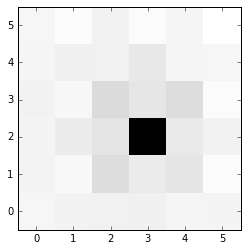

In [7]:
# Show a plot of the stamp
plt.imshow(stamps[0], cmap='Greys')

### Make RGB Masks

The masks are the same for all images so any stamp can be passed. (Could probably also be modified to just accept a shape for the mask)

In [8]:
r_mask, g_mask, b_mask = utils.make_masks(stamps[0])

In [9]:
# View the green mask
g_mask

array([[False,  True, False,  True, False,  True],
       [ True, False,  True, False,  True, False],
       [False,  True, False,  True, False,  True],
       [ True, False,  True, False,  True, False],
       [False,  True, False,  True, False,  True],
       [ True, False,  True, False,  True, False]], dtype=bool)

The masks created above will mask the data where the color currently is, so for the series we want the opposite of the mask, which can be found with the negation operator: `~` (e.g. `~g_mask` will show only green color values)

In [10]:
# Create a masked array that shows only green data (opposite of the g_mask)
r_data = np.ma.array(stamps[0], mask=~r_mask)
g_data = np.ma.array(stamps[0], mask=~g_mask)
b_data = np.ma.array(stamps[0], mask=~b_mask)

g_data

masked_array(data =
 [[-- 2318 -- 2342 -- 2288]
 [2301 -- 2495 -- 2428 --]
 [-- 2373 -- 3637 -- 2319]
 [2315 -- 2508 -- 2495 --]
 [-- 2336 -- 2404 -- 2274]
 [2266 -- 2319 -- 2280 --]],
             mask =
 [[ True False  True False  True False]
 [False  True False  True False  True]
 [ True False  True False  True False]
 [False  True False  True False  True]
 [ True False  True False  True False]
 [False  True False  True False  True]],
       fill_value = 999999)

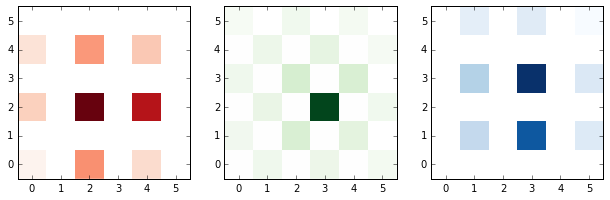

In [11]:
# Plot one stamp
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(10.5, 10.5)
ax1.imshow(r_data, cmap='Reds')
ax2.imshow(g_data, cmap='Greens')
ax3.imshow(b_data, cmap='Blues')

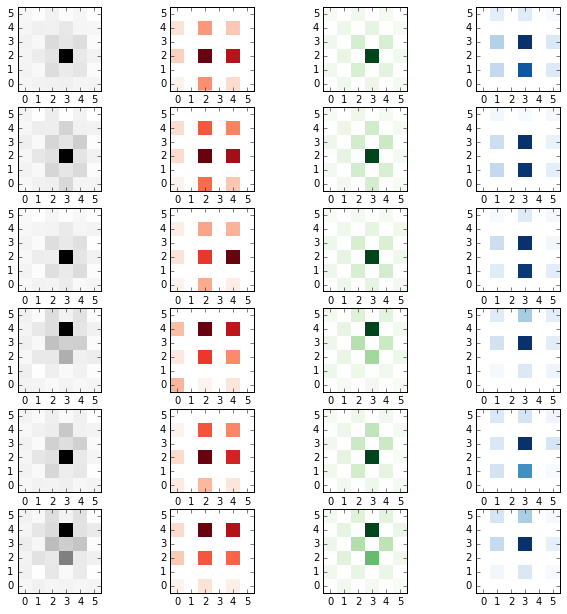

In [12]:
# Show a number of stamps together along with the full stamp
num_stamps = 6
fig, ax = plt.subplots(num_stamps,4)
fig.set_size_inches(10.5, 10.5)

for i in range(num_stamps):
    ax[i][0].imshow(stamps[i], cmap='Greys')
    ax[i][1].imshow(np.ma.array(stamps[i], mask=~r_mask), cmap='Reds')
    ax[i][2].imshow(np.ma.array(stamps[i], mask=~g_mask), cmap='Greens')
    ax[i][3].imshow(np.ma.array(stamps[i], mask=~b_mask), cmap='Blues')

### Create Sequence Data

Create a pandas data `Series` for each color channel that contains the sum of the values for each color. So `r_series` will be a list of data, with the first entry in the list being the sum of all the red pixels for the first image in the sequence. There is a total of one entry per image in the sequence.

In [13]:
r_series = pd.Series([np.ma.array(psc, mask=~r_mask).sum() for psc in stamps])
g_series = pd.Series([np.ma.array(psc, mask=~g_mask).sum() for psc in stamps])
b_series = pd.Series([np.ma.array(psc, mask=~b_mask).sum() for psc in stamps])

Create a normalized `Series` of data by dividing each of the above values by the `max` value for that series.

In [14]:
r_norm = pd.Series([r / r_series.max() for r in r_series])
g_norm = pd.Series([g / g_series.max() for g in g_series])
b_norm = pd.Series([b / b_series.max() for b in b_series])

Create a DataFrame (which is just like a table or a data cube) from the normalized data

In [15]:
norms = pd.DataFrame({
        'R': r_norm,
        'G': g_norm,
        'B': b_norm,
    })

#### Visualize the data

We use the `seaborn` library because it is pretty and gives some convenience methods (see `factorplot` below)

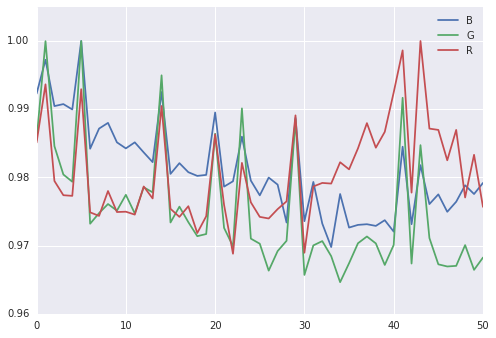

In [16]:
import seaborn as sns
norms.plot()

We convert the data from "wide" format to "long" format by using the `pandas.melt` method (similar to a pivot table). This gives us a `DataFrame` that has one column corresponding to the value type (`R`, `G`, or `B` in our case) and one column for the value itself. We also add an `image_num` column.

In [17]:
# Add a column for image number
norms['image_num'] = pd.Series([i for i in range(len(times))])

# melt the data into long format
lc_data = pd.melt(norms, id_vars=['image_num'], value_vars=list('RGB'), var_name='color')

lc_data[0:6]

,image_num,color,value
0,0,R,0.985115
1,1,R,0.993648
2,2,R,0.979474
3,3,R,0.977388
4,4,R,0.977293
5,5,R,0.992937


View the individual color channels

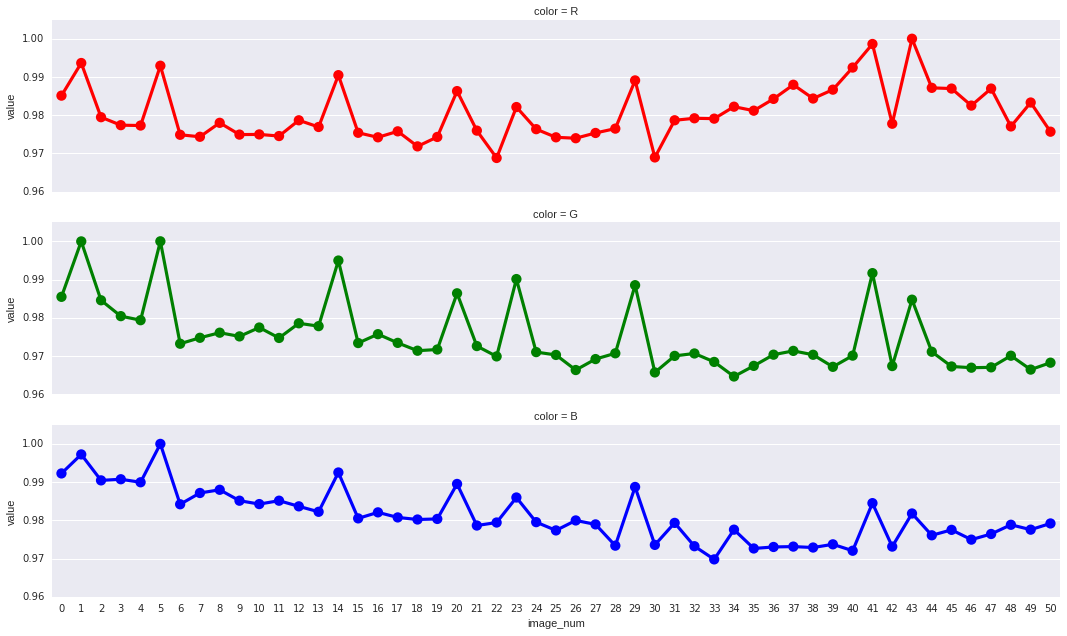

In [18]:
sns.factorplot(x='image_num', y='value', hue='color', row='color', data=lc_data, 
               size=3, aspect=5.0, palette={'R': 'r', 'G': 'g', 'B': 'b'})